In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import pandas_datareader as web
import yfinance as yf
import time  # Import the time module
import os  # Import the os module
from sklearn.model_selection import TimeSeriesSplit

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path

In [43]:
# reshape 2D dataset (samples + features) en 3D (samples/time step + features + séquence) 
# en ajoutant la dimension fenêtre/séquence (longueur est window_size) N, pour prédire N+1. 
# y_pos est la position de colonnes du target. Normalament la prémière colonne
# dataset.shape[0] est le nombre des échantillons
def rnn_3D_data(dataset, window_size, y_pos=0): 
    X = []
    y = []
    for i in range(window_size, dataset.shape[0]):
        X.append(dataset[i-window_size: i])
        y.append(dataset[i, y_pos])
    X, y = np.array(X), np.array(y)
    return X, y

In [44]:
def data_retrieve(stock, start_date, end_date): 

# Define the list of tickers for the stocks you want to fetch data for
    tickers = [stock]

    # Define the list of stock indices and other features
    indices = ['^GSPC', '^DJI', '^IXIC', 'DX-Y.NYB', '^GDAXI', '^FTSE', '^N225', '^VIX']
    commodities = ['GC=F', 'BZ=F']
    forex = ['EURUSD=X', 'JPY=X']

    symbols = indices + commodities + forex
    # Fetch the historical data using yfinance for tickers (OHLC and Volume)
    ticker_data = yf.download(tickers, start=start_date, end=end_date)

    # Fetch the historical data using yfinance for indices and commodities (Close Price)
    close_data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Concatenate the close_data with the ticker_data to include Close Price for all symbols
    all_data = pd.concat([ticker_data, close_data], axis=1)

# Print the data
    return all_data

In [45]:
# Définir le modèle avec cycle scaling, reshing, compile, entrainement
def GRU_M4(df, data_training, data_testing, win_size, num_epoch, num_cell, batch_size, dropout):

    scalar = MinMaxScaler()

    data_training_scaled = scalar.fit_transform(data_training)
    X_train, y_train = rnn_3D_data(data_training_scaled, window_size=win_size, y_pos=3)
    
    # add the winodw before test data
    data_test = pd.concat([data_training.tail(win_size), data_testing], ignore_index=True)
    data_test_scaled = scalar.fit_transform(data_test)
    X_test, y_test = rnn_3D_data(data_test_scaled, window_size=win_size, y_pos=3)
    
    y_scaler_train = MinMaxScaler()
    y_scaler_train.fit(data_training["Close"].values.reshape(-1, 1))
    y_scaler_test = MinMaxScaler()
    y_scaler_test.fit(data_test["Close"].values.reshape(-1, 1))
    
    model = Sequential()

    model.add(GRU(units=num_cell, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))  # 256, return_sequences = True
    model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
#    model.add(Dense(32))
    model.add(Dense(units=1))    
    
#    model.add(GRU(units = num_cell, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
#    model.add(Dropout(dropout))
#    model.add(Dense(units = 1))

    start_time = time.time()
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    rnn_path = (results_path / 'gru_M0.h5').as_posix()
    checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)
    
    lstm_training = model.fit(X_train, y_train, epochs=num_epoch, batch_size = batch_size,\
                        shuffle=True, validation_data=(X_test, y_test),\
                        callbacks=[early_stopping, checkpointer],
                        verbose=0)     
    
    end_time = time.time()
    execution_time = end_time - start_time   
    
    # evaluer le modèle
    # transforme MSE en RMSE
    loss_history = pd.DataFrame(lstm_training.history).pow(.5)
    loss_history.index += 1
#calcule la valeur minimale de la colonne val_loss dans le DataFrame loss_history, 
#ce qui correspond au meilleur RMSE de validation atteint par le modèle.
    best_rmse = loss_history.val_loss.min()
    
    resultat = ['GRU_M4',win_size,num_cell, num_epoch, batch_size, dropout, round(best_rmse, 4), round(execution_time, 0)]
    return model, resultat, lstm_training, scalar,  X_train, y_train, X_test, y_test, y_scaler_train, y_scaler_test

# Parameters

In [46]:
win_size = 60
num_epoch = 100
num_cell = 50
batch_size = 64
dropout = 0.5
split_date = '2020-12-31'
# pour stocker les modèles 
results_path = Path('models', 'GRU_M0')
if not results_path.exists():
    results_path.mkdir(parents=True)

# 1. Raw data collection

In [47]:
start_date = datetime.datetime(2010, 1, 2)
end_date = datetime.datetime.today()

In [48]:
raw_data = yf.download('^GSPC', start=start_date, end=end_date)
raw_data.to_parquet('sp500_data.parquet')

[*********************100%***********************]  1 of 1 completed


In [49]:
raw_data.to_parquet('sp500_data.parquet')

In [50]:
data = pd.read_parquet('sp500_data.parquet')

In [51]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [52]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 3430 number of days in the dataset.


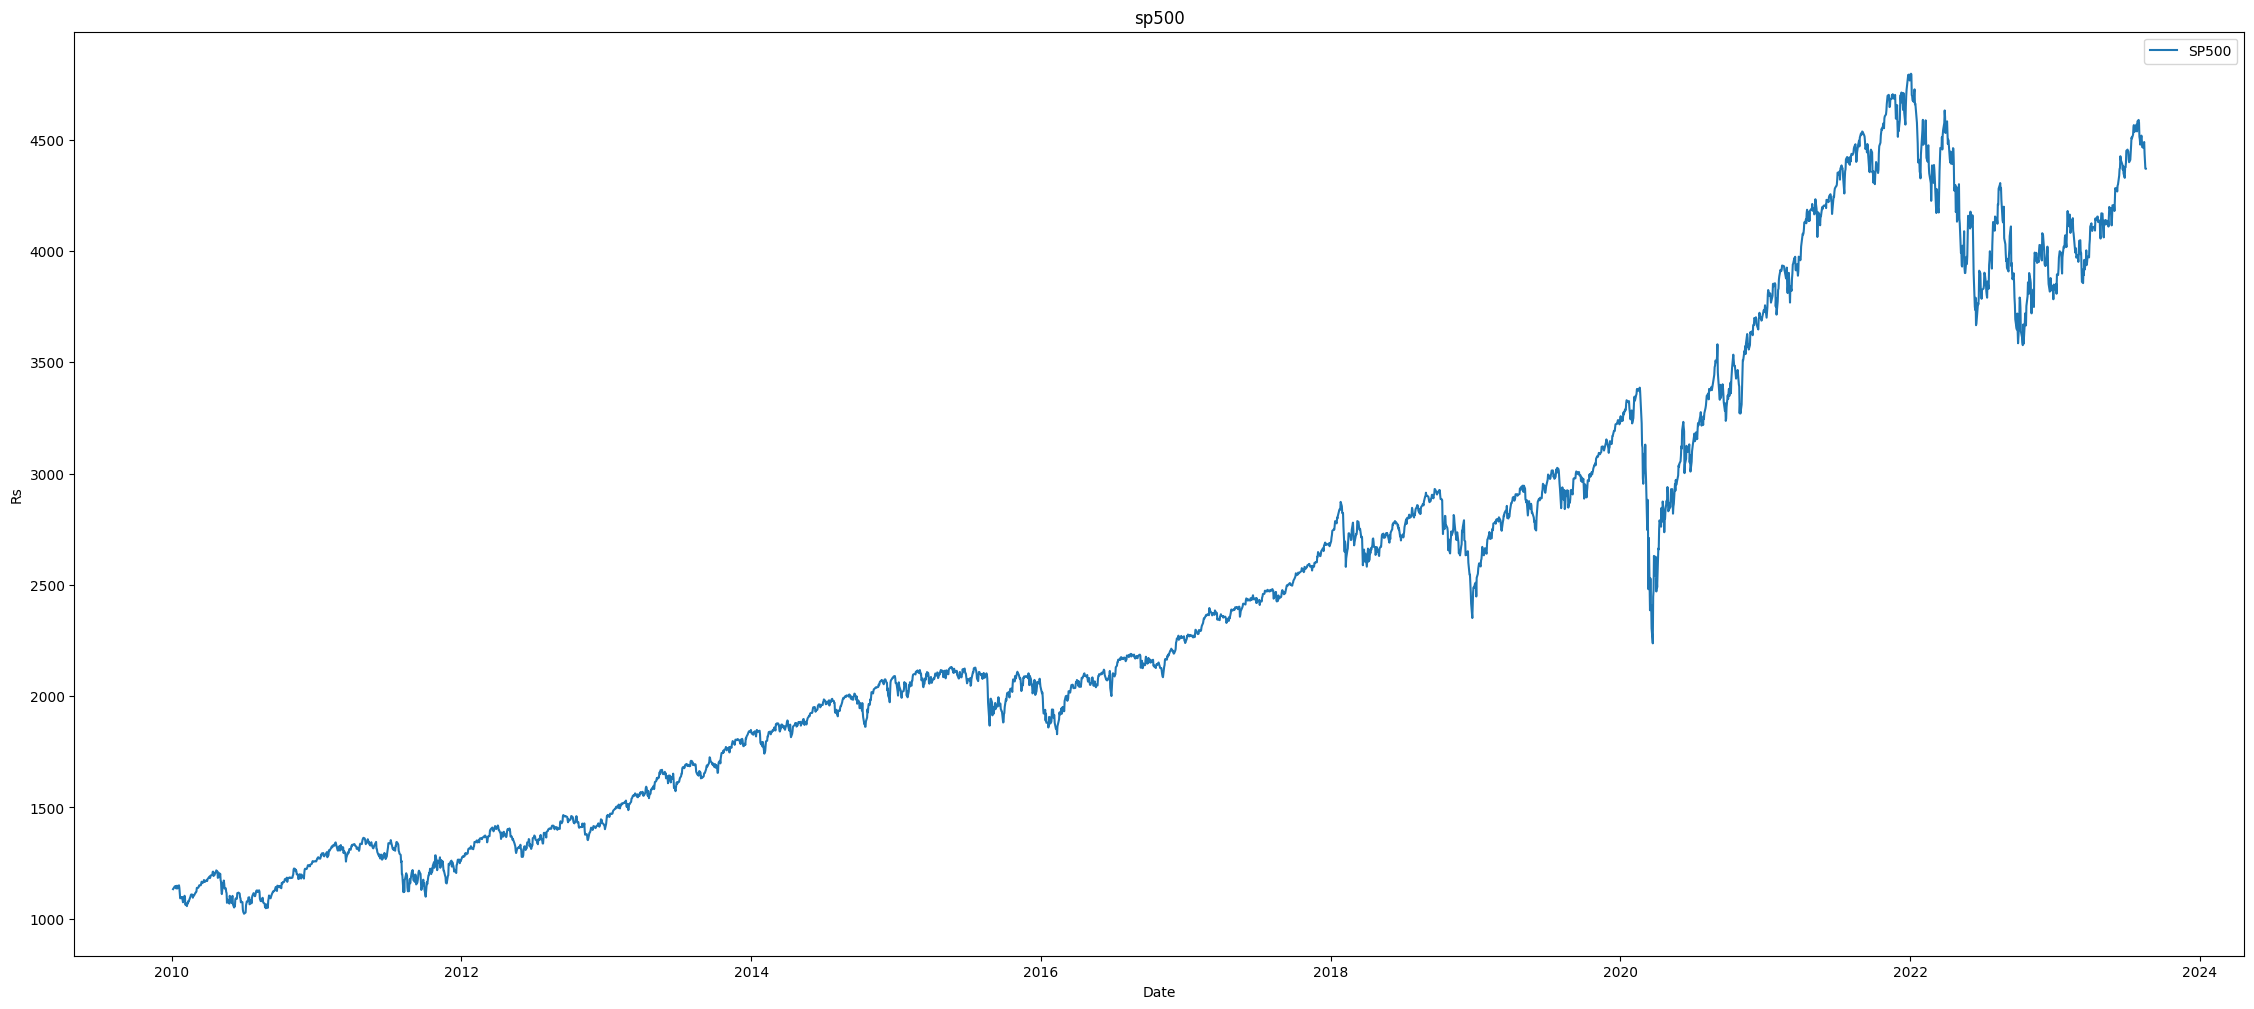

In [53]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Adj Close'], label='SP500')
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('sp500')
plt.legend()
plt.show()

In [54]:
df = data.copy()
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [55]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 3430 samples, and 6 features.


# 2. Feature engineering

In [56]:
FE_df = df

In [57]:
len(FE_df)

3430

# 3. Modèle processing

## 3.1. Data split

In [58]:
data_training = FE_df[FE_df.index < split_date].copy()
data_training.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [59]:
y_train_real_all = data_training["Close"].values.reshape(-1, 1)

In [60]:
#remove the first win_size row which are without prediction
y_train_real = y_train_real_all[win_size:]

In [61]:
data_testing = FE_df[FE_df.index >= split_date].copy()
data_testing.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,3733.270020,3760.199951,3726.879883,3756.070068,3756.070068,3179040000
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5015000000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4591020000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6064110000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5099160000


In [62]:
y_test_real = data_testing["Close"].values.reshape(-1, 1)

In [63]:
#scalar = MinMaxScaler()

#data_training_scaled = scalar.fit_transform(data_training)

## 3.2 Data scaling, reshaping, Model

In [64]:
current_datetime = datetime.datetime.today()
formatted_datetime = current_datetime.strftime('%Y-%m-%d %H:%M')

In [65]:
lstm_model, resultat, model_history, scalar,  X_train, y_train, X_test, y_test, y_scaler_train, y_scaler_test = \
GRU_M4(FE_df, data_training, data_testing, win_size, num_epoch, num_cell, batch_size, dropout)


Epoch 1: val_loss improved from inf to 0.00536, saving model to models/GRU_M0\gru_M0.h5

Epoch 2: val_loss improved from 0.00536 to 0.00253, saving model to models/GRU_M0\gru_M0.h5

Epoch 3: val_loss improved from 0.00253 to 0.00218, saving model to models/GRU_M0\gru_M0.h5

Epoch 4: val_loss improved from 0.00218 to 0.00208, saving model to models/GRU_M0\gru_M0.h5

Epoch 5: val_loss improved from 0.00208 to 0.00170, saving model to models/GRU_M0\gru_M0.h5

Epoch 6: val_loss did not improve from 0.00170

Epoch 7: val_loss did not improve from 0.00170

Epoch 8: val_loss improved from 0.00170 to 0.00168, saving model to models/GRU_M0\gru_M0.h5

Epoch 9: val_loss improved from 0.00168 to 0.00165, saving model to models/GRU_M0\gru_M0.h5

Epoch 10: val_loss did not improve from 0.00165

Epoch 11: val_loss did not improve from 0.00165

Epoch 12: val_loss improved from 0.00165 to 0.00153, saving model to models/GRU_M0\gru_M0.h5

Epoch 13: val_loss improved from 0.00153 to 0.00151, saving mode

In [66]:
resultat.insert(0, formatted_datetime)

In [81]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 60, 50)            8700      
                                                                 
 gru_3 (GRU)                 (None, 64)                22272     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 31,037
Trainable params: 31,037
Non-trainable params: 0
_________________________________________________________________


# 4. Evaluation performance

## 4.1. Scaled performance

In [67]:
def lstm_scaled_perfomance(model_history, start_epoch=1):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(start_epoch, start_epoch + len(model_history.history['loss']))
    
    # loss, val_loss 
    axs[0].plot(epochs, model_history.history['loss'], label='Training Loss')
    axs[0].plot(epochs, model_history.history['val_loss'],  label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validation'], loc='best')
    
    # transforme MSE en RMSE
    loss_history = pd.DataFrame(model_history.history).pow(.5)
    loss_history.index += 1    
#calcule la valeur minimale de la colonne val_loss dans le DataFrame loss_history, 
#ce qui correspond au meilleur RMSE de validation atteint par le modèle.
    best_rmse = loss_history.val_loss.min()
    best_epoch = loss_history.val_loss.idxmin()    
    title = f'Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
    loss_history.columns=['Training RMSE', 'Validation RMSE']
    
    loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=axs[1])    
    axs[1].axvline(best_epoch, ls='--', lw=1, c='k')
    
    sns.despine()
    fig.tight_layout()    
    plt.show()
    return best_rmse, best_epoch

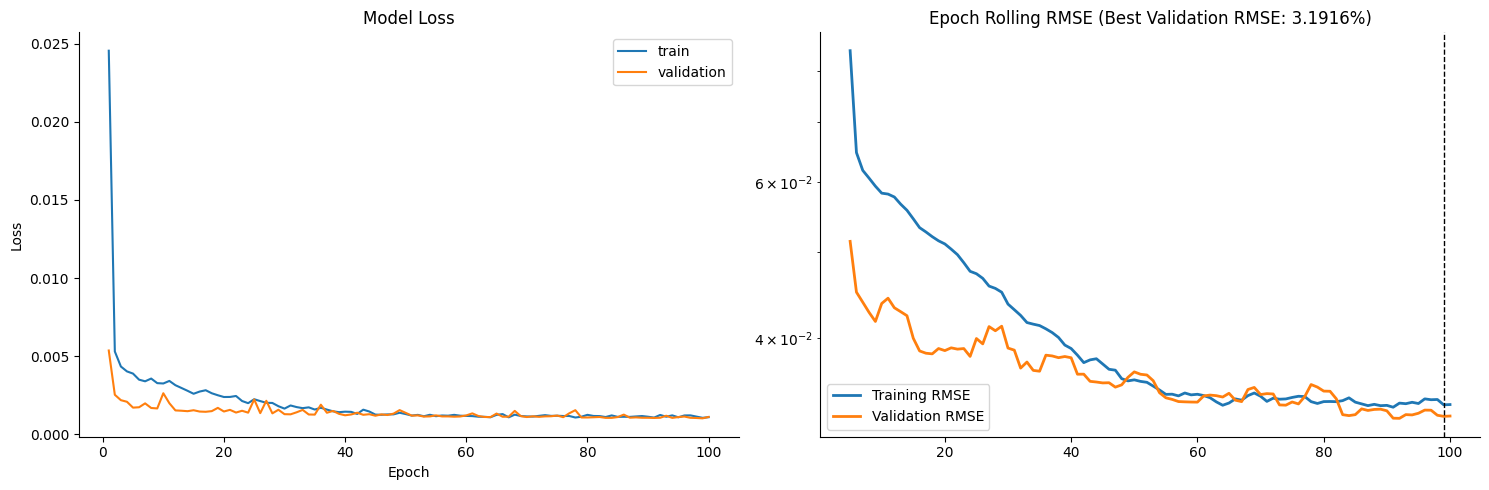

In [68]:
best_rmse, best_epoch = lstm_scaled_perfomance(model_history)

In [69]:
y_train_predict_scaled = lstm_model.predict(X_train)
y_test_predict_scaled = lstm_model.predict(X_test)

21/21 [==============================] - 0s 10ms/step


In [70]:
from scipy.stats import spearmanr
train_ic = spearmanr(y_train, y_train_predict_scaled)[0]
test_ic = spearmanr(y_test, y_test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9990 | Test IC: 0.9838


In [71]:
resultat.extend([round(train_ic, 4), round(test_ic,4)])

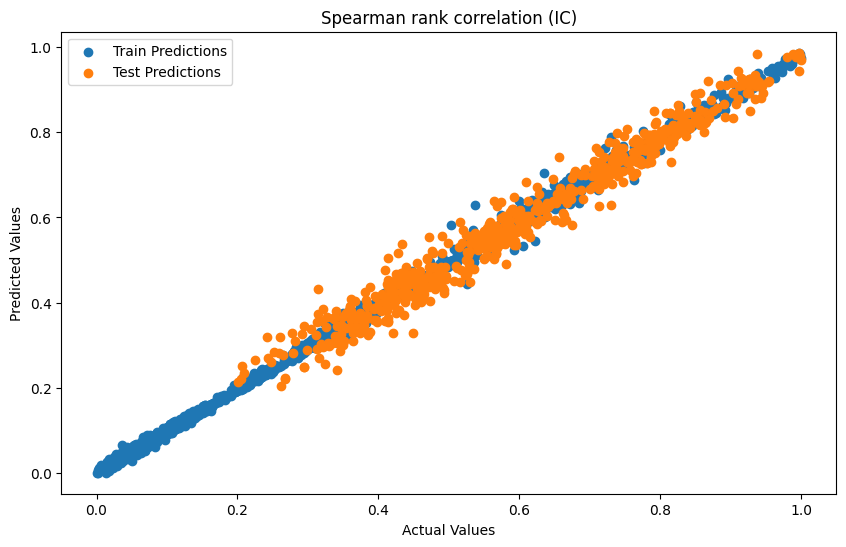

In [72]:
import matplotlib.pyplot as plt

# Plotting the train and test predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_predict_scaled, label='Train Predictions')
plt.scatter(y_test, y_test_predict_scaled, label='Test Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Spearman rank correlation (IC)')
plt.legend()
plt.show()

## 4.2. Rescaled performance

In [73]:
def lstm_real_predict(y_train_real, y_train_predict, y_test_real, y_test_predict):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    axs[0].plot(y_train_real, color = 'red', label = 'Real SP500 Price')
    axs[0].plot(y_train_predict, color = 'blue', label = 'Predicted SP500 Price')
    axs[0].set_title('SP500 Train Price Prediction')
    axs[0].set_ylabel('Price')
    axs[0].set_xlabel('Time')
    axs[0].legend(['Real', 'Predict'], loc='best')

    axs[1].plot(y_test_real, color = 'red', label = 'Real SP500 Price')
    axs[1].plot(y_test_predict, color = 'blue', label = 'Predicted SP500 Price')
    axs[1].set_title('SP500 Test Price Prediction')
    axs[1].set_ylabel('Price')
    axs[1].set_xlabel('Time')
    axs[1].legend(['Real', 'Predict'], loc='best')

    plt.legend()  
    plt.show()
    return

In [74]:
y_test_predict = y_scaler_test.inverse_transform(y_test_predict_scaled)
y_train_predict = y_scaler_train.inverse_transform(y_train_predict_scaled)

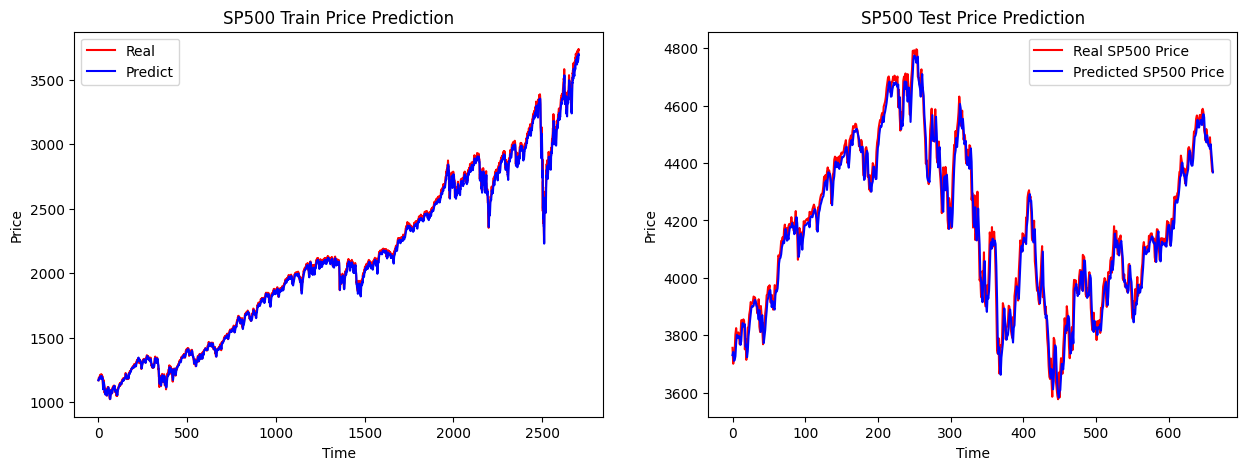

In [75]:
lstm_real_predict(y_train_real, y_train_predict, y_test_real, y_test_predict)

In [76]:
train_rmse_scaled = np.sqrt(lstm_model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(lstm_model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0113 | Test RMSE: 0.0333


In [77]:
resultat.extend([round(train_rmse_scaled, 4), round(test_rmse_scaled,4)])

In [78]:
train_rmse = np.sqrt(mean_squared_error(y_train_predict, y_train_real))
test_rmse = np.sqrt(mean_squared_error(y_test_predict, y_test_real))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 30.55 | Test RMSE: 50.85'

In [79]:
resultat.extend([round(train_rmse, 2), round(test_rmse,2)])

In [80]:
models_performance = pd.read_csv('models_performance.csv', index_col=[0])
models_performance.loc[len(models_performance)] = resultat
models_performance.to_csv('models_performance.csv')

In [89]:
def real_predict_dist(y_train_real, y_train_predict, y_test_real, y_test_predict):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    diff_train = y_train_predict - y_train_real
    diff_test = y_test_predict - y_test_real
    
# Création de l'histogramme de la distribution
    axs[0].hist(diff_train, bins=20, edgecolor='black')
# Ajout de labels et de titres
    axs[0].set_xlabel('Différence entre y_train_predict et y_train_real')
    axs[0].set_ylabel('Fréquence')
    axs[0].set_title('Distribution différence train')

    # Création de l'histogramme de la distribution
    axs[1].hist(diff_test, bins=20, edgecolor='black')
# Ajout de labels et de titres
    axs[1].set_xlabel('Différence entre y_test_predict et y_test_real')
    axs[1].set_ylabel('Fréquence')
    axs[1].set_title('Distribution différence test')

    plt.show()
    return

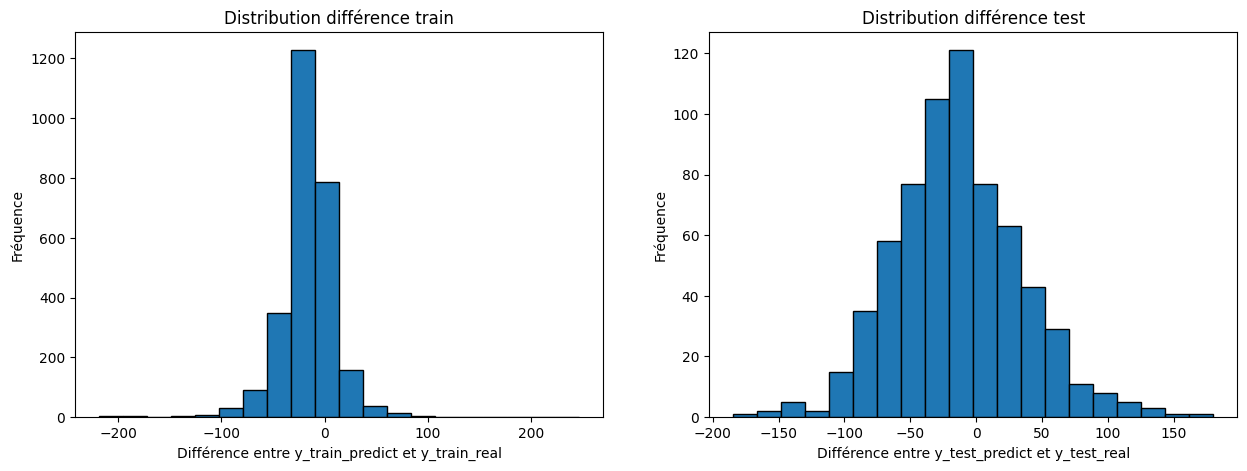

In [90]:
real_predict_dist(y_train_real, y_train_predict, y_test_real, y_test_predict)